jmc님의 최고점과 비교해서 f1 점수 측정

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import f1_score
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

def load_predictions(file_paths):
    """여러 모델의 예측 결과를 로드합니다."""
    predictions = {}
    for path in file_paths:
        model_name = os.path.basename(path).split('.')[0]
        df = pd.read_csv(path)
        # ID 컬럼 중복 제거 및 예측 컬럼 이름 변경
        df = df[['ID', 'target']].rename(columns={'target': model_name})
        predictions[model_name] = df
    return predictions

def find_different_predictions(predictions):
    """모든 모델에서 다르게 예측한 항목을 찾습니다."""
    # 모든 예측을 하나의 DataFrame으로 병합
    all_predictions = predictions[list(predictions.keys())[0]]
    for model, df in list(predictions.items())[1:]:
        all_predictions = pd.merge(all_predictions, df, on='ID', suffixes=('', f'_{model}'))
    
    # 예측 컬럼만 선택
    prediction_columns = [col for col in all_predictions.columns if col != 'ID']
    
    # 예측이 다른 행만 선택
    different_predictions = all_predictions[all_predictions[prediction_columns].nunique(axis=1) > 1]
    return different_predictions

def calculate_macro_f1(ground_truth, predictions):
    """Macro F1 점수를 계산합니다."""
    return f1_score(ground_truth, predictions, average='macro')

def plot_error_distribution(ground_truth, predictions):
    """각 클래스별 오류 예측 개수를 bar plot으로 표시합니다."""
    # 클래스 이름 정의
    class_names = {
        0: "계좌번호(손글씨)", 1: "임신출산 진료비 지급 신청서", 2: "자동차 계기판", 3: "입퇴원 확인서", 4: "진단서", 
        5: "운전면허증", 6: "진료비영수증", 7: "통원/진료 확인서", 8: "주민등록증", 9: "여권", 
        10: "진료비 납입 확인서", 11: "약제비 영수증", 12: "처방전", 13: "이력서", 14: "소견서", 
        15: "자동차 등록증", 16: "자동차 번호판"
    }

    error_counts = {i: 0 for i in range(len(class_names))}  # 모든 클래스에 대해 초기화
    for gt, pred in zip(ground_truth, predictions):
        if gt != pred:
            error_counts[gt] += 1
    
    classes = sorted(error_counts.keys())
    counts = [error_counts[c] for c in classes]
    class_labels = [f"{c}\n{class_names[c]}" for c in classes]
    
    # 나눔 폰트 설정
    font_path = './font/NanumGothic.otf'
    font_prop = FontProperties(fname=font_path)
    
    plt.figure(figsize=(20, 10))
    bars = plt.bar(class_labels, counts)
    plt.title("오류 예측 개수 (클래스별)", fontproperties=font_prop, fontsize=16)
    plt.xlabel("클래스", fontproperties=font_prop, fontsize=14)
    plt.ylabel("오류 개수", fontproperties=font_prop, fontsize=14)
    plt.xticks(rotation=45, ha='center')
    
    # x축 레이블에 폰트 적용
    ax = plt.gca()
    ax.set_xticklabels(class_labels, fontproperties=font_prop, fontsize=10)
    
    plt.tight_layout()
    
    # 각 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom', fontproperties=font_prop)
    
    plt.show()

In [62]:
# 예측 파일 경로
file_paths = [
    "9740.csv",
	'pred_ensemble.csv',
    #'pred_0809_hoho_0_0.csv',
]

# for i in range(0, 15):
#     for j in range(0, 15):
#         file_paths.append(f'pred_0808_hoho_{i}_{j}.csv')

# 이미지 디렉토리 경로
image_dir = "datasets_fin/test"

In [63]:

# 예측 로드
predictions = load_predictions(file_paths)

# 다른 예측 찾기
# different_predictions = find_different_predictions(predictions)

# # 결과 출력
# print(different_predictions)

# Macro F1 점수 계산
ground_truth_name = os.path.basename(file_paths[0]).split('.')[0]
ground_truth = predictions[ground_truth_name][ground_truth_name]

macro_f1_list = []

for i in range(1, len(predictions)):
    prediction_name = os.path.basename(file_paths[i]).split('.')[0]
    prediction = predictions[prediction_name][prediction_name]
    macro_f1 = calculate_macro_f1(ground_truth, prediction)
    
    macro_f1_list.append(
        {
            'macro_f1': macro_f1,
            'filename': os.path.basename(file_paths[i]),
        }
    )

macro_f1_list.sort(key=lambda x: x['macro_f1'])

for x in macro_f1_list:
    print(f"Macro F1 Score: {x['macro_f1']},  csv filename: {x['filename']}")
    

Macro F1 Score: 0.9692750851413081,  csv filename: pred_ensemble.csv


/tmp/ipykernel_681564/2425547269.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_labels, fontproperties=font_prop, fontsize=10)


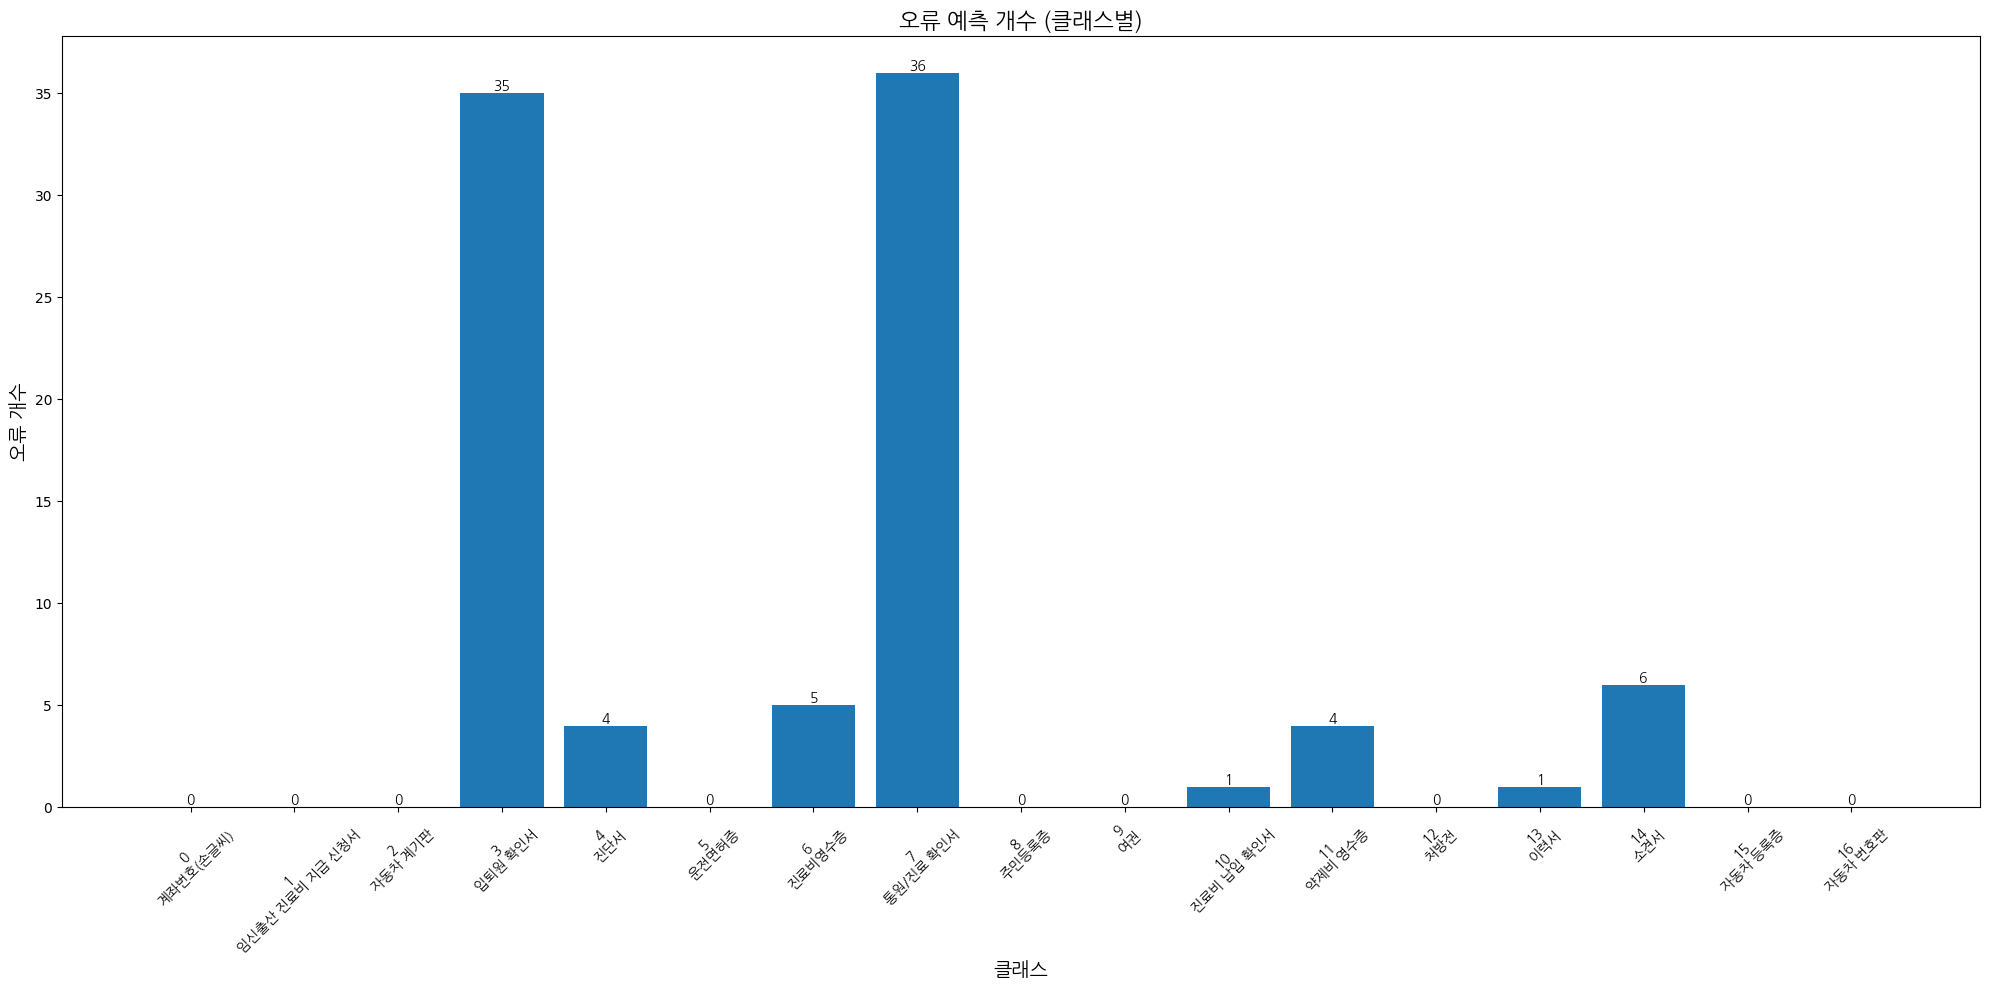

In [64]:
prediction_name = os.path.basename(file_paths[-1]).split('.')[0]
prediction = predictions[prediction_name][prediction_name]

# 오류 분포 그래프 표시
plot_error_distribution(ground_truth, prediction)